--- 🔬 Simulating Model-Level Optimization: Non-Transformer Architecture ---
Simulating generation for 4096 tokens...

--- Simulation Summary ---
Memory usage at the end of generating 4096 tokens:
Standard Transformer Total VRAM: 3.703 GB
Non-Transformer Total VRAM:    3.000 GB

✅ Non-Transformer architecture saved 0.703 GB of VRAM over the sequence.

📊 Graph saved as 'non_transformer_simulation.png'


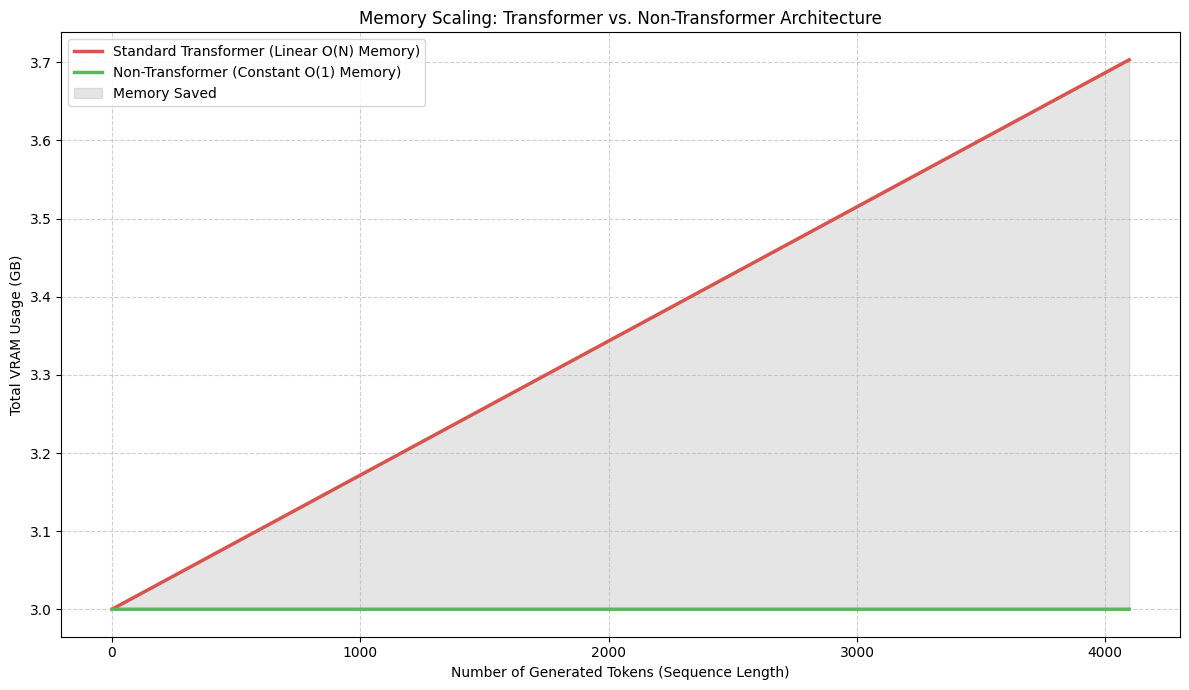

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURATION ---
# We'll use parameters from gpt2-large for a consistent comparison.
# We'll assume the Non-Transformer model has similar base parameters for fairness.
MODEL_CONFIG = {
    "num_layers": 36,
    "hidden_size": 1280,
    "base_model_vram_gb": 3.0
}

# --- SIMULATION PARAMETERS ---
GENERATION_LENGTH = 4096  # A long generation to clearly show the scaling difference
BATCH_SIZE = 1
BYTES_PER_ELEMENT = 2     # For FP16 precision

def calculate_transformer_cache_vram(config, sequence_length):
    """Calculates the VRAM for a standard, growing KV cache."""
    num_layers = config["num_layers"]
    hidden_size = config["hidden_size"]
    
    # Formula: Batch * SeqLen * Layers * 2 (for K,V) * HiddenSize * Bytes
    total_bytes = (
        BATCH_SIZE * sequence_length * num_layers * 2 * hidden_size * BYTES_PER_ELEMENT
    )
    return total_bytes / (1024**3)

def calculate_recurrent_state_vram(config):
    """
    Calculates the VRAM for a fixed-size recurrent state (like in RWKV or Mamba).
    The state size is independent of sequence length. A common formulation is Batch * Layers * HiddenSize.
    """
    num_layers = config["num_layers"]
    hidden_size = config["hidden_size"]
    
    # A simplified formula for the state size: Batch * Layers * HiddenSize * Bytes
    # Note: Different recurrent models (Mamba, RWKV) have slightly different state sizes.
    # This captures the key idea that it's constant.
    total_bytes = (
        BATCH_SIZE * num_layers * hidden_size * BYTES_PER_ELEMENT
    )
    return total_bytes / (1024**3)

def main():
    print("--- 🔬 Simulating Model-Level Optimization: Non-Transformer Architecture ---")

    # --- 1. Prepare for simulation ---
    token_steps = range(1, GENERATION_LENGTH + 1)
    transformer_vram_history = []
    nontransformer_vram_history = []

    base_vram = MODEL_CONFIG["base_model_vram_gb"]
    
    # Calculate the fixed state size for the Non-Transformer model once
    recurrent_state_vram = calculate_recurrent_state_vram(MODEL_CONFIG)
    nontransformer_total_vram = base_vram + recurrent_state_vram

    # --- 2. Run the step-by-step simulation ---
    print(f"Simulating generation for {GENERATION_LENGTH} tokens...")
    for i in token_steps:
        # Transformer's VRAM grows at each step
        transformer_cache_vram = calculate_transformer_cache_vram(MODEL_CONFIG, i)
        transformer_vram_history.append(base_vram + transformer_cache_vram)
        
        # Non-Transformer's VRAM stays constant
        nontransformer_vram_history.append(nontransformer_total_vram)

    # --- 3. Print Final Summary ---
    print("\n--- Simulation Summary ---")
    print(f"Memory usage at the end of generating {GENERATION_LENGTH} tokens:")
    print(f"Standard Transformer Total VRAM: {transformer_vram_history[-1]:.3f} GB")
    print(f"Non-Transformer Total VRAM:    {nontransformer_vram_history[-1]:.3f} GB")
    
    savings = transformer_vram_history[-1] - nontransformer_vram_history[-1]
    print(f"\n✅ Non-Transformer architecture saved {savings:.3f} GB of VRAM over the sequence.")

    # --- 4. Plot the results ---
    plt.figure(figsize=(12, 7))
    plt.plot(token_steps, transformer_vram_history, label='Standard Transformer (Linear O(N) Memory)', color='#d9534f', linewidth=2.5)
    plt.plot(token_steps, nontransformer_vram_history, label='Non-Transformer (Constant O(1) Memory)', color='#5cb85c', linewidth=2.5)
    
    # Shade the area between the lines to represent the memory savings
    plt.fill_between(token_steps, nontransformer_vram_history, transformer_vram_history, color='gray', alpha=0.2, label='Memory Saved')
    
    plt.xlabel('Number of Generated Tokens (Sequence Length)')
    plt.ylabel('Total VRAM Usage (GB)')
    plt.title('Memory Scaling: Transformer vs. Non-Transformer Architecture')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig("non_transformer_simulation.png")
    print("\n📊 Graph saved as 'non_transformer_simulation.png'")
    plt.show()

if __name__ == "__main__":
    main()